# Predicting Company Sales vs with Alternative Data (web traffic)

In [7]:
import psycopg2
import numpy as np
import pandas as pd
from scipy import stats
import datetime as dt
import statsmodels.api as sm
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Import the data from Postgresql as dataframe:

In [8]:
DB_NAME = ''
DB_USER = ''
DB_PWD = ''
DB_HOST = ''
DB_PORT = ''

try:
    connection = psycopg2.connect(user = DB_USER,
                                  password = DB_PWD,
                                  host = DB_PWD ,
                                  port = DB_PORT,
                                  database = DB_NAME)
    cursor = connection.cursor()
    print ( connection.get_dsn_parameters(),"\n")
#     cursor.execute("SELECT company_id, date, traffic FROM trafficdata INNER JOIN salesestimate ON trafficdata.company_id=salesestimate.company_id;")
#     record = cursor.fetchall()
#     record = cursor.execute("SELECT * FROM trafficdata;")
    record_traffic = pd.read_sql("SELECT * FROM trafficdata;",connection)
#     record_traffic = pd.DataFrame(cursor.fetchall())
#     cursor.execute("SELECT * FROM eodfundamentalsdata;")
    record_eod = pd.read_sql("SELECT * FROM eodfundamentalsdata;",connection)
    record_sales = pd.read_sql("SELECT * FROM salesestimate;",connection)
#     print("You are connected to - ", record,"\n")
    
except (Exception, psycopg2.Error) as error :
    print ("Error while connecting to PostgreSQL", error)
    
finally:
    #closing database connection.
        if(connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")

{'user': 'altcap_usr', 'dbname': 'altcap_db', 'host': '167.99.88.131', 'port': '5432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

PostgreSQL connection is closed


In [9]:
asos_traffic = record_traffic[record_traffic["company_id"]==1]
asos_sales = record_sales[record_sales["company_id"]==1]
# asos_sales.head()

In [10]:
asos_sales.date = asos_sales.date.map(lambda x: x.strftime('%Y-%m-%d'))
asos_sales_sum = asos_sales[["date","analysis_mean"]]
# asos_sales = asos_sales.groupby(["date"])['analysis_mean'].sum()
# asos_sales_sum.head()

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [11]:
asos_traffic_daily = asos_traffic[asos_traffic["period"]=="daily"]
asos_traffic_daily.date = asos_traffic_daily["date"].map(lambda x: x.strftime('%Y-%m-%d'))
asos_traffic_sum = asos_traffic_daily[["date","traffic","period"]]
# asos_traffic_sum.head()

In [12]:
df_total = pd.merge(asos_sales_sum, asos_traffic_sum,on="date",how='inner')
df_total.head()

,date,analysis_mean,traffic,period
0,2019-03-01,2.787650e+09,10687,daily
1,2019-03-02,2.787650e+09,5785,daily
2,2019-03-03,2.787650e+09,4674,daily
3,2019-03-04,2.787650e+09,9087,daily
4,2019-03-05,2.787650e+09,9092,daily


In [13]:
X = df_total[["traffic"]].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)

y = df_total[["analysis_mean"]].values.astype(float)
y_scaled = min_max_scaler.fit_transform(y)

In [14]:
model = sm.OLS (x_scaled,y_scaled)
results = model.fit()
params = results.params
params

array([0.18111052])

(0, 1)

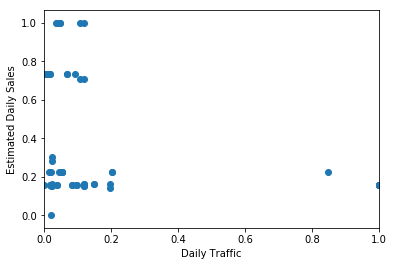

In [15]:
plt.scatter(x_scaled,y_scaled)
plt.xlabel("Daily Traffic")
plt.ylabel("Estimated Daily Sales")
plt.xlim(0,1)

In [16]:
df_traffic_and_sales = pd.DataFrame({"traffic":x_scaled.flatten(),"sales":y_scaled.flatten()})
df_traffic_and_sales.head()

,traffic,sales
0,0.093448,0.734955
1,0.017266,0.734955
2,0.000000,0.734955
3,0.068582,0.734955
4,0.068660,0.734955


In [17]:
df_traffic_and_sales_sum = df_traffic_and_sales.groupby("sales")[["traffic"]].mean()
type (df_traffic_and_sales_sum)
df_traffic_and_sales_sum

,traffic
sales,
0.000000,0.019939
0.139565,0.196422
0.153649,0.070696
0.158771,0.471942
0.162612,0.126019
0.224072,0.154734
0.280410,0.022395
0.300896,0.023296
0.708067,0.112921


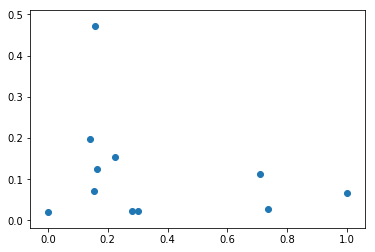

In [18]:
plt.scatter(df_traffic_and_sales_sum.index, df_traffic_and_sales_sum.traffic)

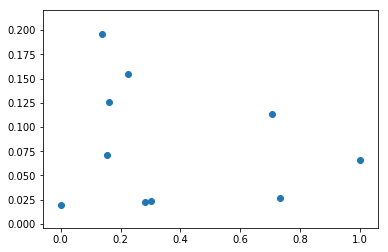

In [19]:
z = np.abs(stats.zscore(df_traffic_and_sales_sum))
df_traffic_and_sales_sum = df_traffic_and_sales_sum[(z<1.9).all(axis=1)]
df_traffic_and_sales_sum
plt.scatter(df_traffic_and_sales_sum.index,df_traffic_and_sales_sum)

# Generalised Additive Model

In [20]:
import pygam
gam = pygam.LogisticGAM().fit(df_traffic_and_sales_sum['traffic'],df_traffic_and_sales_sum.index)
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      0.8387
Link Function:                        LogitLink Log Likelihood:                                       -inf
Number of Samples:                           10 AIC:                                                   inf
                                                AICc:                                                  inf
                                                UBRE:                                               2.7172
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                  -0.0068
Feature Function                  Lam

/anaconda3/lib/python3.7/site-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/anaconda3/lib/python3.7/site-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  This is separate from the ipykernel package so we can avoid doing imports until


# Introduce EOD data

In [21]:
record_eod_quarterly = record_eod[record_eod.frequency=='quarterly']
record_eod_quarterly.date = record_eod_quarterly.date.map(lambda x: x.strftime('%Y-%m-%d'))
record_eod_quarterly.fillna(method='ffill')
record_eod_quarterly.head()

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,id,date,frequency,total_revenue,ebit,company_id
19,3968,2019-02-28,quarterly,657250000.0,2250000.0,1
20,3969,2018-11-30,quarterly,657250000.0,2250000.0,1
21,3970,2018-08-31,quarterly,629600000.0,36100000.0,1
22,3971,2018-05-31,quarterly,629600000.0,36100000.0,1
23,3972,2018-02-28,quarterly,579050000.0,14850000.0,1


In [22]:
dict_traffic={}
for i,j in zip(record_eod_quarterly.loc[:,'date'], record_eod_quarterly.loc[20:,'date']):
    total_traffic=asos_traffic[(asos_traffic['date'] < i) & (asos_traffic['date'] >=j)]['traffic'].sum()
    dict_traffic.update({i:total_traffic})
record_eod_summary=pd.DataFrame.from_dict(dict_traffic,orient='index')
record_eod_summary.columns=['traffic']
record=pd.merge(record_eod_summary,record_eod_quarterly,left_index=True,right_on='date',how='inner')
record.fillna(method='ffill')
record.head()

,traffic,id,date,frequency,total_revenue,ebit,company_id
19,160817,3968,2019-02-28,quarterly,657250000.0,2250000.0,1
20,14226,3969,2018-11-30,quarterly,657250000.0,2250000.0,1
21,15588,3970,2018-08-31,quarterly,629600000.0,36100000.0,1
22,19720,3971,2018-05-31,quarterly,629600000.0,36100000.0,1
23,24221,3972,2018-02-28,quarterly,579050000.0,14850000.0,1


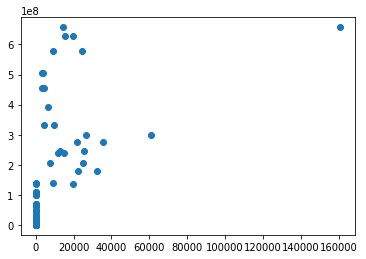

In [23]:
plt.scatter(record['traffic'],record['total_revenue'])

We have an outlier on the top right because this is calculated from the sum of daily values of traffic, whereas other points are calculated from monthly values. There might be problems with the daily values or unit difference. For simplicity, we discard this point for the time being. We also discard all values with zero because that means there is no data at that point.

In [24]:
record_cleaned=record.loc[~(record==0).any(axis=1)]
record_cleaned=record_cleaned.loc[20:,:]
record_cleaned.fillna(method='ffill')
record_cleaned.head()

,traffic,id,date,frequency,total_revenue,ebit,company_id
20,14226,3969,2018-11-30,quarterly,657250000.0,2250000.0,1
21,15588,3970,2018-08-31,quarterly,629600000.0,36100000.0,1
22,19720,3971,2018-05-31,quarterly,629600000.0,36100000.0,1
23,24221,3972,2018-02-28,quarterly,579050000.0,14850000.0,1
24,9077,3973,2017-11-30,quarterly,579050000.0,14850000.0,1


Text(0, 0.5, 'Quarterly Revenue')

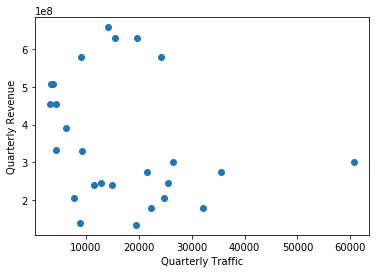

In [25]:
plt.scatter(record_cleaned['traffic'],record_cleaned['total_revenue'])
plt.xlabel('Quarterly Traffic')
plt.ylabel('Quarterly Revenue')

# Random Forest Regressor

In [26]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [27]:
def rfr_model(X, y):
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=False, verbose=False)

    scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

    return scores

In [28]:
record_cleaned = record_cleaned.fillna(method='ffill')
# X=np.array(record_cleaned.loc['traffic']).reshape(-1,1)
X = record_cleaned[['traffic']].values.astype(float)
X_scaled = min_max_scaler.fit_transform(X)
# y=np.array(record_cleaned.total_revenue).reshape(-1,1)
y = record_cleaned[['total_revenue']].values.astype(float)
y_scaled = min_max_scaler.fit_transform(y)
score=rfr_model(X_scaled,y_scaled)
score

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed 

array([-0.73715083, -0.49218351, -0.15415807, -0.12976833, -0.08906912,
       -0.13422129, -0.65898628, -0.33086571, -0.21143793, -0.64996389])

# Neural Network

In [29]:
import torch
import pandas as pd
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [30]:
x = torch.FloatTensor(X_scaled)
y = torch.FloatTensor(y_scaled)
x, y = Variable(x), Variable(y)

In [76]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.fc1 (x)
        out = self.relu (out)
        out = self.fc2 (out)
        return out

In [77]:
net = Net(input_size=1, hidden_size=15, num_classes=1)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)

for epoch in range (5000):
    inputs = x
    target = y
    out = net (inputs)
    loss = criterion (out, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
    if epoch%20 == 0:
        print ('Epoch[{}], loss:{:.6f}'.format(epoch,loss.data))

Epoch[0], loss:0.374945
Epoch[20], loss:0.335285
Epoch[40], loss:0.298502
Epoch[60], loss:0.264926
Epoch[80], loss:0.234353
Epoch[100], loss:0.206607
Epoch[120], loss:0.181598
Epoch[140], loss:0.159218
Epoch[160], loss:0.139333
Epoch[180], loss:0.122021
Epoch[200], loss:0.107176
Epoch[220], loss:0.094492
Epoch[240], loss:0.083788
Epoch[260], loss:0.074909
Epoch[280], loss:0.067649
Epoch[300], loss:0.061788
Epoch[320], loss:0.057122
Epoch[340], loss:0.053462
Epoch[360], loss:0.050637
Epoch[380], loss:0.048490
Epoch[400], loss:0.046883
Epoch[420], loss:0.045699
Epoch[440], loss:0.044838
Epoch[460], loss:0.044220
Epoch[480], loss:0.043781
Epoch[500], loss:0.043471
Epoch[520], loss:0.043251
Epoch[540], loss:0.043095
Epoch[560], loss:0.042983
Epoch[580], loss:0.042899
Epoch[600], loss:0.042835
Epoch[620], loss:0.042783
Epoch[640], loss:0.042740
Epoch[660], loss:0.042702
Epoch[680], loss:0.042667
Epoch[700], loss:0.042635
Epoch[720], loss:0.042605
Epoch[740], loss:0.042576
Epoch[760], loss:0

In [78]:
y_pred = net(x)
print((y_pred,y),y_pred-y)

(tensor([[0.4377],
        [0.4230],
        [0.3782],
        [0.3295],
        [0.4934],
        [0.5540],
        [0.5509],
        [0.5438],
        [0.5567],
        [0.5349],
        [0.5228],
        [0.5442],
        [0.4904],
        [0.2249],
        [0.3054],
        [0.2325],
        [0.3580],
        [0.3148],
        [0.4531],
        [0.4295],
        [0.4655],
        [0.5079],
        [0.3237],
        [0.3494],
        [0.2426],
        [0.2044],
        [0.4953],
        [0.3814]], grad_fn=<AddmmBackward>), tensor([[1.0000],
        [0.9471],
        [0.9471],
        [0.8503],
        [0.8503],
        [0.7105],
        [0.7105],
        [0.6142],
        [0.6142],
        [0.6142],
        [0.4900],
        [0.3804],
        [0.3764],
        [0.3163],
        [0.3163],
        [0.2686],
        [0.2686],
        [0.2143],
        [0.2143],
        [0.2028],
        [0.2028],
        [0.1338],
        [0.1338],
        [0.0860],
        [0.0860],
        [0.0860],
